# Introduction
This tutorial shows how a H2O [Deep Learning](http://en.wikipedia.org/wiki/Deep_learning) model can be used to do supervised classification and regression. This tutorial covers usage of H2O from R. A python version of this tutorial will be available as well in a separate document. This file is available in plain R, R markdown and regular markdown formats, and the plots are available as PDF files. More examples and explanations can be found in our [H2O Deep Learning booklet](http://h2o.ai/resources/) and on our [H2O Github Repository](http://github.com/h2oai/h2o-3/).


### H2O Python Module

Load the H2O Python module.

In [1]:
import h2o


### Start H2O
Start up a 1-node H2O server on your local machine, and allow it to use all CPU cores and up to 2GB of memory:

In [2]:
h2o.init(max_mem_size_GB = 2)            #uses all cores by default
h2o.remove_all()                          #clean slate, in case cluster was already running

H2O cluster uptime:,2 hours 38 minutes 14 seconds 656 milliseconds
H2O cluster version:,3.7.0.3248
H2O cluster name:,H2O_started_from_python
H2O cluster total nodes:,1
H2O cluster total memory:,1.78 GB
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54321


To learn more about the h2o package itself, we can use Python's builtin help() function.

In [3]:
help(h2o)

Help on package h2o:

NAME
    h2o

FILE
    d:\anaconda\lib\site-packages\h2o\__init__.py

DESCRIPTION
    The H2O Python Module
    
    This module provides access to the H2O JVM, as well as its extensions, objects,
    machine-learning algorithms, and modeling support capabilities, such as basic
    munging and feature generation.
    
    The H2O JVM uses a web server so that all communication occurs on a socket (specified
    by an IP address and a port) via a series of REST calls (see connection.py for the REST
    layer implementation and details). There is a single active connection to the H2O JVM at
    any time, and this handle is stashed out of sight in a singleton instance of
    :class:`H2OConnection` (this is the global  :envvar:`__H2OConn__`). In other words,
    this package does not rely on Jython, and there is no direct manipulation of the JVM.
    
    The H2O python module is not intended as a replacement for other popular machine learning
    frameworks such as sc

help() can be used on H2O functions and models. Jupyter's builtin shift-tab functionality also works

In [4]:
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator
help(H2ODeepLearningEstimator)
help(h2o.import_file)

Help on class H2ODeepLearningEstimator in module h2o.estimators.deeplearning:

class H2ODeepLearningEstimator(h2o.estimators.estimator_base.H2OEstimator)
 |  Method resolution order:
 |      H2ODeepLearningEstimator
 |      h2o.estimators.estimator_base.H2OEstimator
 |      h2o.model.model_base.ModelBase
 |      __builtin__.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, model_id=None, overwrite_with_best_model=None, checkpoint=None, use_all_factor_levels=None, activation=None, hidden=None, epochs=None, train_samples_per_iteration=None, seed=None, adaptive_rate=None, rho=None, epsilon=None, rate=None, rate_annealing=None, rate_decay=None, momentum_start=None, momentum_ramp=None, momentum_stable=None, nesterov_accelerated_gradient=None, input_dropout_ratio=None, hidden_dropout_ratios=None, l1=None, l2=None, max_w2=None, initial_weight_distribution=None, initial_weight_scale=None, loss=None, distribution=None, tweedie_power=None, score_interval=None, score_training_samples=

##H2O Deep Learning
While H2O Deep Learning has many parameters, it was designed to be just as easy to use as the other supervised training methods in H2O. Early stopping, automatic data standardization and handling of categorical variables and missing values and adaptive learning rates (per weight) reduce the amount of parameters the user has to specify. Often, it's just the number and sizes of hidden layers, the number of epochs and the activation function and maybe some regularization techniques.


### Let's have some fun first: Decision Boundaries
We start with a small dataset representing red and black dots on a plane, arranged in the shape of two nested spirals. Then we task H2O's machine learning methods to separate the red and black dots, i.e., recognize each spiral as such by assigning each point in the plane to one of the two spirals.

We visualize the nature of H2O Deep Learning (DL), H2O's tree methods (GBM/DRF) and H2O's generalized linear modeling (GLM) by plotting the decision boundary between the red and black spirals:

In [5]:
%matplotlib inline                        
#IMPORT ALL THE THINGS

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from h2o.estimators.deeplearning import H2OAutoEncoderEstimator, H2ODeepLearningEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

First, we need to upload our datasets to the the H2O cluster. The data is imported into H2OFrames, which operate similarly in function to pandas DataFrames.  

In this case, the cluster is running on our laptops. Data files are imported by their relative locations to this notebook.

In [6]:
spiral = h2o.upload_file("../data/spiral.csv")
grid  = h2o.upload_file("../data/grid.csv")


Parse Progress: [##################################################] 100%

Parse Progress: [##################################################] 100%


Spiral is a simple data set consisting of two spirals of black and red dots.  
Grid is a 201 by 201 matrix with dimensions [-1.5, 1.5] by [-1.5, 1.5].

To visualize these datasets, we can pull them from H2OFrames into pandas DataFrames for easier plotting.

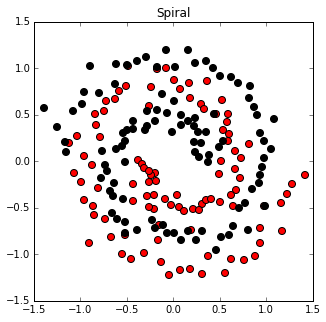

In [7]:
spiral_df = spiral.as_data_frame(use_pandas=True)
grid_df = grid.as_data_frame(use_pandas=True)
grid_x, grid_y = grid_df.x.reshape(201,201), grid_df.y.reshape(201,201)
spiral_r = spiral_df[spiral_df.color == "Red"]
spiral_k = spiral_df[spiral_df.color == "Black"]

spiral_xr, spiral_yr = spiral_r[spiral_r.columns[0]], spiral_r[spiral_r.columns[1]]
spiral_xk, spiral_yk = spiral_k[spiral_k.columns[0]], spiral_k[spiral_k.columns[1]]
    
markersize_ = 7**2
plt.figure(figsize = (5,5))
plt.scatter(spiral_xr, spiral_yr, c = 'r', s=markersize_)
plt.scatter(spiral_xk, spiral_yk, c = 'k', s=markersize_)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title("Spiral");

###Model Construction
H2O in Python is designed to be very similar in look and feel to to scikit-learn. Models are initialized individually with desired or default parameters and then trained on data.  

Note that the below examples use model.train(), as opposed the traditional model.fit()
This is because h2o-py takes the data frame AND column indices for the feature and response columns, while scikit-learn takes in feature frames.

H2O supports model.fit() so that it can be incorporated into a scikit-learn pipeline, but we advise using train() in all other cases.

In [8]:
X = spiral.col_names[0:2]
y = spiral.col_names[2]
dl_model = H2ODeepLearningEstimator(epochs=1000)
dl_model.train(X, y, spiral)

gbm_model = H2OGradientBoostingEstimator()
gbm_model.train(X, y, spiral)

drf_model = H2ORandomForestEstimator()
drf_model.train(X, y, spiral)

glm_model = H2OGeneralizedLinearEstimator(family="binomial")
glm_model.fit(spiral[X], spiral[y])                                #model.fit() example

models = [dl_model, gbm_model, drf_model, glm_model]
m_names = ["Deep Learning", "Gradient Boosted Method", "Distributed Random Forest", "Generalized Linear Model"]



deeplearning Model Build Progress: [##################################################] 100%

gbm Model Build Progress: [##################################################] 100%

drf Model Build Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%


D:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:13: UserWarning: 

	`fit` is not recommended outside of the sklearn framework. Use `train` instead.


Now that we've trained four models to classify points as red or black based on their (x,y) coordinates.  
To see how our models have performed, we ask them to predict the colors of the grid.

Since we'll be doing a lot of spiral plotting, let's write a little helper function to keep things clean.

In [79]:
def plot_spirals(models, model_names):
    fig, ax = plt.subplots(2,2, figsize=(12,12))
    for k, subplot in enumerate(ax.flatten()):
        subplot.scatter(spiral_xr, spiral_yr, c = 'r', s=markersize_)
        subplot.scatter(spiral_xk, spiral_yk, c = 'k', s=markersize_)
        subplot.axis([-1.5, 1.5, -1.5, 1.5])
        subplot.set_title(model_names[k])
        subplot.set_xlabel('x')
        subplot.set_ylabel('y')
        pred_z = models[k].predict(grid).as_data_frame(True)
        subplot.contour(grid_x, grid_y, (pred_z['predict'] == 'Black').astype(np.int).reshape(201,201), colors='b')

Below are four graphs of the contour plots of the predictions, so that we can see how exactly the algorithms grouped the points into black and red.

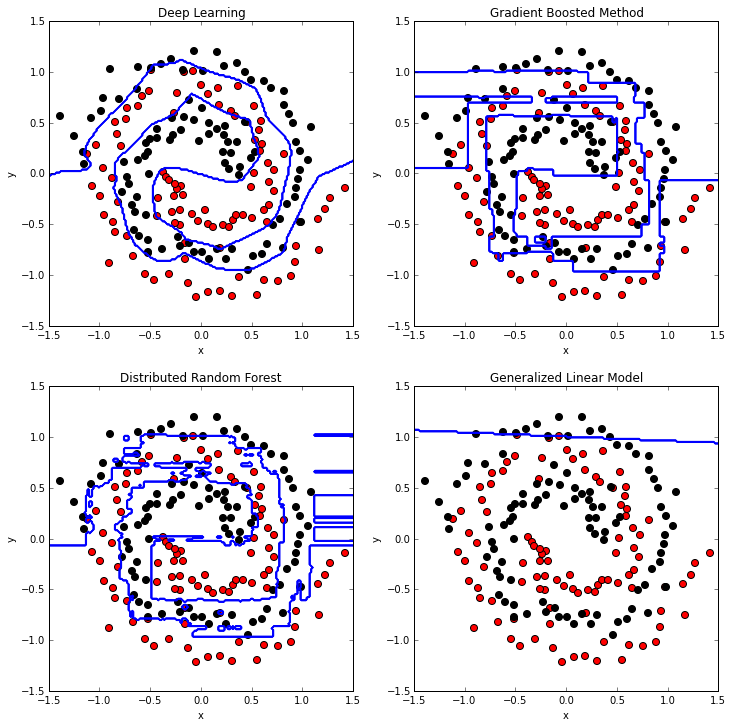

In [37]:
plot_spirals(models, m_names)

###A Deeper Dive into Deep Learning

Now let's explore the evolution of our deep learning model over training time (number of passes over the data, aka epochs).  
We will use checkpointing to ensure that we continue training the same model

In [77]:
dl_1 = H2ODeepLearningEstimator(epochs=1)
dl_1.train(X, y, spiral)

dl_250 = H2ODeepLearningEstimator(checkpoint=dl_1, epochs=250)
dl_250.train(X, y, spiral)

dl_500 = H2ODeepLearningEstimator(checkpoint=dl_250, epochs=500)
dl_500.train(X, y, spiral)

dl_750 = H2ODeepLearningEstimator(checkpoint=dl_500, epochs=750)
dl_750.train(X, y, spiral)


deeplearning Model Build Progress: [##################################################] 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1446836648403_98

Status of Neuron Layers: predicting color, 2-class classification, bernoulli distribution, CrossEntropy loss, 41,202 weights/biases, 490.7 KB, 215 training samples, mini-batch size 1



,layer,units,type,dropout,l1,l2,mean_rate,rate_RMS,momentum,mean_weight,weight_RMS,mean_bias,bias_RMS
,1,2,Input,0.0,,,,,,,,,
,2,200,Rectifier,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.5,0.0
,3,200,Rectifier,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.1,1.0,0.0
,4,2,Softmax,,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.0




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.49988548011
R^2: -0.99954192044
LogLoss: 4.79551574949
AUC: 0.3529
Gini: -0.2942

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.999198300904:


,Black,Red,Error,Rate
Black,0.0,100.0,1.0,(100.0/100.0)
Red,0.0,100.0,0.0,(0.0/100.0)
Total,0.0,200.0,0.5,(100.0/200.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,1.0,0.7,195.0
max f2,1.0,0.8,195.0
max f0point5,1.0,0.6,195.0
max accuracy,1.0,0.5,195.0
max precision,1.0,0.5,195.0
max absolute_MCC,1.0,0.3,103.0
max min_per_class_accuracy,1.0,0.36,96.0



Scoring History:


,timestamp,duration,training_speed,epochs,samples,training_MSE,training_r2,training_logloss,training_AUC,training_classification_error
,2015-11-06 17:10:08,0.000 sec,None,0.0,0.0,nan,nan,nan,nan,nan
,2015-11-06 17:10:08,0.014 sec,3857 rows/sec,0.135,27.0,0.5,-1.0,4.8,0.3529,0.5
,2015-11-06 17:10:08,0.065 sec,3981 rows/sec,1.075,215.0,0.5,-1.0,4.9,0.645,0.445
,2015-11-06 17:10:08,0.072 sec,3771 rows/sec,1.075,215.0,0.5,-1.0,4.8,0.3529,0.5



deeplearning Model Build Progress: [##################################################] 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1446836648403_100

Status of Neuron Layers: predicting color, 2-class classification, bernoulli distribution, CrossEntropy loss, 41,202 weights/biases, 490.7 KB, 50,000 training samples, mini-batch size 1



,layer,units,type,dropout,l1,l2,mean_rate,rate_RMS,momentum,mean_weight,weight_RMS,mean_bias,bias_RMS
,1,2,Input,0.0,,,,,,,,,
,2,200,Rectifier,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.2,0.3,0.1
,3,200,Rectifier,0.0,0.0,0.0,0.3,0.2,0.0,-0.1,0.2,0.8,0.4
,4,2,Softmax,,0.0,0.0,0.0,0.0,0.0,0.0,0.4,0.0,0.1




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.15473716882
R^2: 0.381051324719
LogLoss: 0.476949953407
AUC: 0.8556
Gini: 0.7112

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.307635380423:


,Black,Red,Error,Rate
Black,65.0,35.0,0.35,(35.0/100.0)
Red,7.0,93.0,0.07,(7.0/100.0)
Total,72.0,128.0,0.21,(42.0/200.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3,0.8,127.0
max f2,0.3,0.9,133.0
max f0point5,0.8,0.8,75.0
max accuracy,0.4,0.795,118.0
max precision,1.0,1.0,0.0
max absolute_MCC,0.3,0.6,127.0
max min_per_class_accuracy,0.6,0.75,99.0



Scoring History:


,timestamp,duration,training_speed,epochs,samples,training_MSE,training_r2,training_logloss,training_AUC,training_classification_error
,2015-11-06 17:10:11,0.000 sec,None,0.0,0.0,nan,nan,nan,nan,nan
,2015-11-06 17:10:11,0.277 sec,7352 rows/sec,10.0,2000.0,0.2,0.0,0.7,0.6519,0.44
,2015-11-06 17:10:14,2.810 sec,17850 rows/sec,250.0,50000.0,0.2,0.4,0.5,0.8556,0.21



deeplearning Model Build Progress: [##################################################] 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1446836648403_102

Status of Neuron Layers: predicting color, 2-class classification, bernoulli distribution, CrossEntropy loss, 41,202 weights/biases, 490.7 KB, 100,000 training samples, mini-batch size 1



,layer,units,type,dropout,l1,l2,mean_rate,rate_RMS,momentum,mean_weight,weight_RMS,mean_bias,bias_RMS
,1,2,Input,0.0,,,,,,,,,
,2,200,Rectifier,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.3
,3,200,Rectifier,0.0,0.0,0.0,0.3,0.3,0.0,-0.0,0.2,0.7,0.5
,4,2,Softmax,,0.0,0.0,0.0,0.1,0.0,-0.0,0.4,-0.0,0.1




ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.0806211523999
R^2: 0.6775153904
LogLoss: 0.278653395705
AUC: 0.9659
Gini: 0.9318

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.593653826779:


,Black,Red,Error,Rate
Black,85.0,15.0,0.15,(15.0/100.0)
Red,3.0,97.0,0.03,(3.0/100.0)
Total,88.0,112.0,0.09,(18.0/200.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6,0.9,108.0
max f2,0.3,1.0,115.0
max f0point5,0.9,0.9,80.0
max accuracy,0.6,0.91,108.0
max precision,1.0,1.0,0.0
max absolute_MCC,0.6,0.8,108.0
max min_per_class_accuracy,0.8,0.87,95.0



Scoring History:


,timestamp,duration,training_speed,epochs,samples,training_MSE,training_r2,training_logloss,training_AUC,training_classification_error
,2015-11-06 17:10:16,0.000 sec,None,0.0,0.0,nan,nan,nan,nan,nan
,2015-11-06 17:10:17,0.314 sec,6472 rows/sec,10.0,2000.0,0.4,-0.5,1.5,0.605,0.435
,2015-11-06 17:10:22,5.385 sec,17857 rows/sec,480.0,96000.0,0.1,0.6,0.3,0.9613,0.11
,2015-11-06 17:10:22,5.547 sec,18070 rows/sec,500.0,100000.0,0.1,0.7,0.3,0.9659,0.09



deeplearning Model Build Progress: [##################################################] 100%


You can see how the network learns the structure of the spirals with enough training time. 

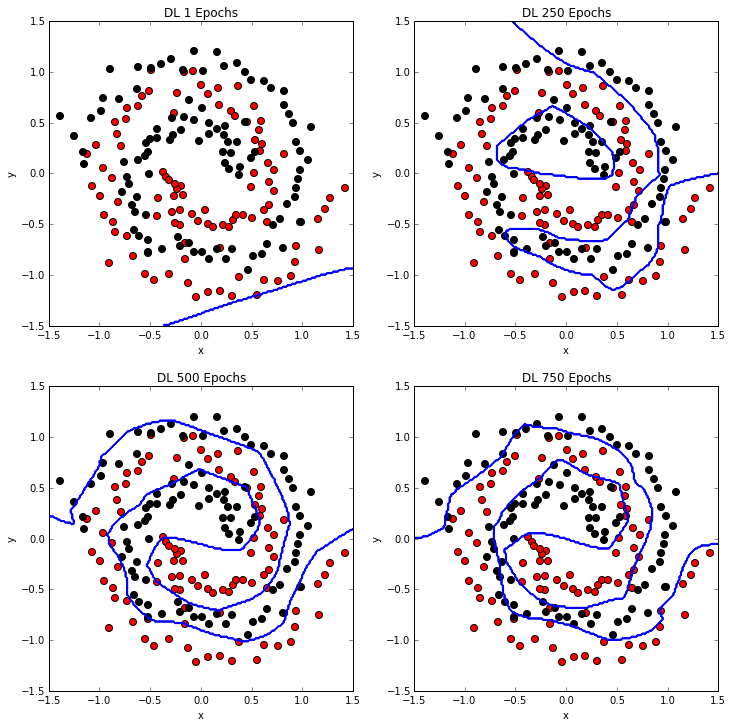

In [80]:
models_dl = [dl_1, dl_250, dl_500, dl_750]
m_names_dl = ["DL " + str(int(model.get_params()['epochs']['actual_value'])) + \
                                     " Epochs" for model in models_dl]

plot_spirals(models_dl, m_names_dl)

###Deep Learning Network Architecture
Of course, there is far more to constructing Deep Learning models than simply having them run longer.  
Consider the four following setups.

1. Single layer, 1000 nodes
2. Two layers, 200 nodes each
3. Three layers, 42 nodes each
4. Four layers, 11 -> 13 -> 17 -> 19

The H2O Architecture uses the hidden keyword to control model network architecture.  
Hidden takes a list of integers, representing the number of nodes in each layer.

In [30]:
dl_1 = H2ODeepLearningEstimator(hidden=[1000], epochs=500)
dl_1.train(X, y, spiral)

dl_2 = H2ODeepLearningEstimator(hidden=[200,200], epochs=500)
dl_2.train(X, y, spiral)

dl_3 = H2ODeepLearningEstimator(hidden=[42,42,42], epochs=500)
dl_3.train(X, y, spiral)

dl_4 = H2ODeepLearningEstimator(hidden=[11,13,17,19], epochs = 1000)
dl_4.train(X, y, spiral)


deeplearning Model Build Progress: [##################################################] 100%

deeplearning Model Build Progress: [##################################################] 100%

deeplearning Model Build Progress: [##################################################] 100%

deeplearning Model Build Progress: [##################################################] 100%


It is clear that different configurations can achieve similar performance, and that tuning will be required for optimal performance.

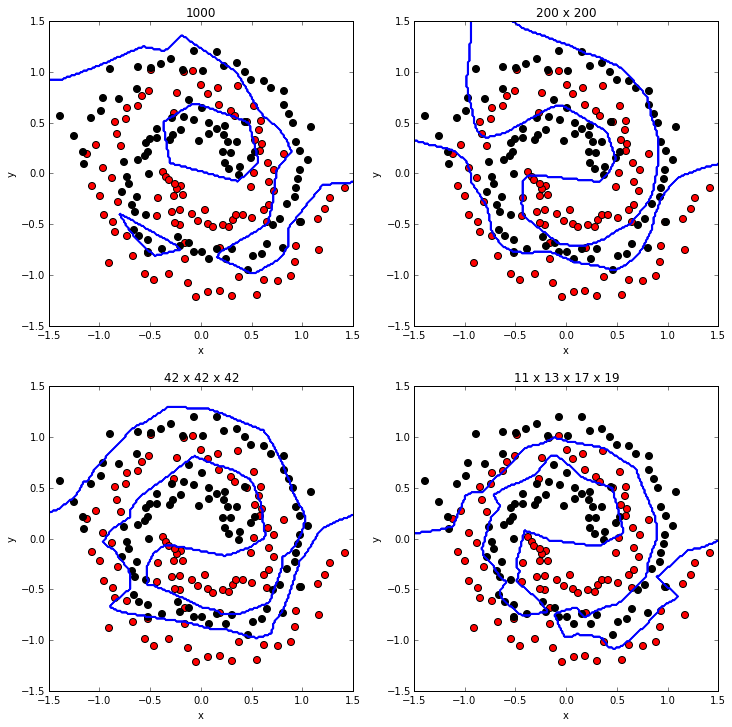

In [31]:
models_network = [dl_1, dl_2, dl_3, dl_4]
m_names_network = ["1000", "200 x 200", "42 x 42 x 42", "11 x 13 x 17 x 19"]

plot_spirals(models_network, m_names_network)

###Activation Functions
Next, we compare between different activation functions, including one with 50% dropout regularization in the hidden layers:

In [33]:
models_act = []
m_names_act = []
for i,method in enumerate(["Tanh","Maxout","Rectifier","RectifierWithDropout"]):
    models_act.append(H2ODeepLearningEstimator(activation=method, hidden=[100,100], epochs=1000))
    models_act[i].train(X, y, spiral)
    m_names_act.append("DL "+ method + " Activation")


deeplearning Model Build Progress: [##################################################] 100%

deeplearning Model Build Progress: [##################################################] 100%

deeplearning Model Build Progress: [##################################################] 100%

deeplearning Model Build Progress: [##################################################] 100%


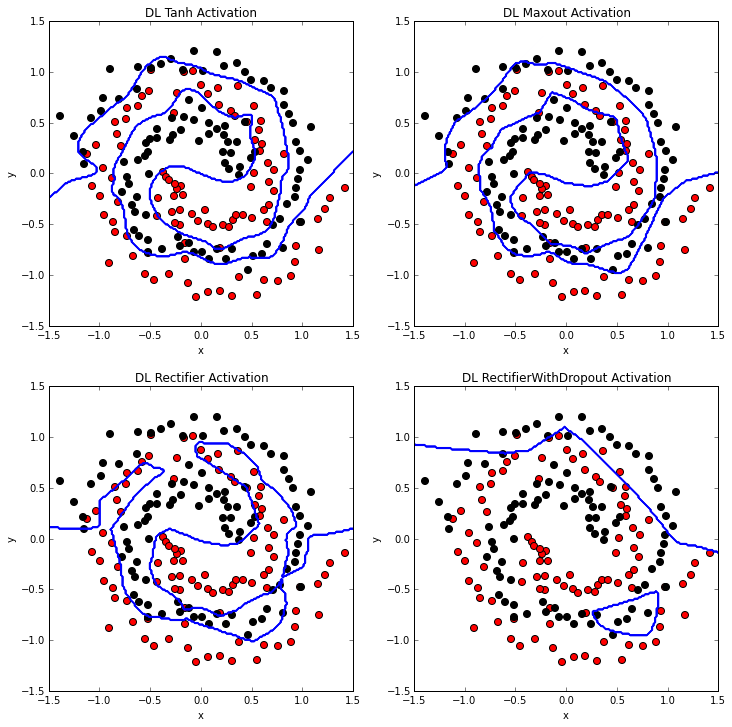

In [35]:
plot_spirals(models_act, m_names_act)

Clearly, the dropout rate was too high or the number of epochs was too low for the last configuration, which often ends up performing the best on larger datasets where generalization is important.  

More information about the parameters can be found in the [H2O Deep Learning booklet](http://h2o.ai/resources/).

## Covertype Dataset
The following examples use the Covertype dataset from UC Irvine, which concerns predicting forest cover based on cartographical data.  
We import the full covertype dataset (581k rows, 13 columns, 10 numerical, 3 categorical) and then split the data 3 ways:  
  
60% for training  
20% for validation (hyper parameter tuning)  
20% for final testing  

In [85]:
covtype_df = h2o.import_file("../data/covtype.full.csv")

#split the data as described above
train, valid, test = covtype_df.split_frame([0.6, 0.2], seed=1234)

#Prepare predictors and response columns
covtype_X = covtype_df.col_names[:-1]     #last column is cover_type, 
covtype_y = covtype_df.col_names[-1]    


Parse Progress: [##################################################] 100%


####First Impressions
Let's run our first Deep Learning model on the covtype dataset.   
We want to predict the `Cover_Type` column, a categorical feature with 7 levels, and the Deep Learning model will be tasked to perform (multi-class) classification. It uses the other 12 predictors of the dataset, of which 10 are numerical, and 2 are categorical with a total of 44 levels.  

We can expect the Deep Learning model to have 56 input neurons (after automatic one-hot encoding). First run will be only one epoch to get a feel for the model construction.

In [88]:
#set the model_id for easy lookup in Flow
covtype_model_v1 = H2ODeepLearningEstimator(model_id="covtype_v1", epochs=1, variable_importances=True)
covtype_model_v1.train(covtype_X, covtype_y, training_frame = train, validation_frame = valid)
print covtype_model_v1


deeplearning Model Build Progress: [##################################################] 100%
Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  covtype_v1

Status of Neuron Layers: predicting Cover_Type, 7-class classification, multinomial distribution, CrossEntropy loss, 53,007 weights/biases, 634.4 KB, 348,872 training samples, mini-batch size 1



,layer,units,type,dropout,l1,l2,mean_rate,rate_RMS,momentum,mean_weight,weight_RMS,mean_bias,bias_RMS
,1,56,Input,0.0,,,,,,,,,
,2,200,Rectifier,0.0,0.0,0.0,0.1,0.2,0.0,-0.0,0.1,0.0,0.1
,3,200,Rectifier,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.1,0.7,0.4
,4,7,Softmax,,0.0,0.0,0.1,0.2,0.0,-0.3,0.5,-0.5,0.1




ModelMetricsMultinomial: deeplearning
** Reported on train data. **

MSE: 0.134348654154
R^2: 0.92858274886
LogLoss: 0.433599572509

Confusion Matrix: vertical: actual; across: predicted



class_1,class_2,class_3,class_4,class_5,class_6,class_7,Error,Rate
3331.0,356.0,0.0,0.0,0.0,4.0,21.0,0.1,"381 / 3,712"
892.0,3914.0,40.0,0.0,8.0,33.0,6.0,0.2,"979 / 4,893"
0.0,28.0,528.0,6.0,0.0,53.0,0.0,0.1,87 / 615
0.0,1.0,20.0,11.0,0.0,6.0,0.0,0.7,27 / 38
20.0,95.0,6.0,0.0,42.0,3.0,0.0,0.7,124 / 166
1.0,40.0,98.0,0.0,0.0,144.0,0.0,0.5,139 / 283
113.0,0.0,0.0,0.0,0.0,0.0,223.0,0.3,113 / 336
4357.0,4434.0,692.0,17.0,50.0,243.0,250.0,0.2,"1,850 / 10,043"



Top-7 Hit Ratios:


k,hit_ratio
1,0.8157921
2,1.0
3,1.0
4,0.999303
5,1.0
6,1.0
7,1.0



ModelMetricsMultinomial: deeplearning
** Reported on validation data. **

MSE: 0.138915569579
R^2: 0.929130135785
LogLoss: 0.452196235286

Confusion Matrix: vertical: actual; across: predicted



class_1,class_2,class_3,class_4,class_5,class_6,class_7,Error,Rate
37264.0,4460.0,1.0,0.0,5.0,25.0,232.0,0.1,"4,723 / 41,987"
10712.0,44977.0,465.0,0.0,75.0,379.0,38.0,0.2,"11,669 / 56,646"
1.0,418.0,6025.0,24.0,1.0,689.0,0.0,0.2,"1,133 / 7,158"
0.0,2.0,199.0,234.0,0.0,88.0,0.0,0.6,289 / 523
272.0,1039.0,53.0,0.0,479.0,26.0,0.0,0.7,"1,390 / 1,869"
28.0,383.0,1162.0,9.0,0.0,1850.0,0.0,0.5,"1,582 / 3,432"
1337.0,29.0,0.0,0.0,0.0,0.0,2808.0,0.3,"1,366 / 4,174"
49614.0,51308.0,7905.0,267.0,560.0,3057.0,3078.0,0.2,"22,152 / 115,789"



Top-7 Hit Ratios:


k,hit_ratio
1,0.8086865
2,0.9823731
3,0.9972364
4,1.0
5,0.9999654
6,1.0
7,1.0



Scoring History:


,timestamp,duration,training_speed,epochs,samples,training_MSE,training_r2,training_logloss,training_classification_error,validation_MSE,validation_r2,validation_logloss,validation_classification_error
,2015-11-06 17:24:19,0.000 sec,None,0.0,0.0,nan,nan,nan,nan,nan,nan,nan,nan
,2015-11-06 17:24:23,5.509 sec,8598 rows/sec,0.1,34805.0,0.2,0.9,0.6,0.3,0.2,0.9,0.6,0.3
,2015-11-06 17:24:38,21.045 sec,11499 rows/sec,0.6,208635.0,0.2,0.9,0.5,0.2,0.2,0.9,0.5,0.2
,2015-11-06 17:24:49,32.209 sec,12616 rows/sec,1.0,348872.0,0.1,0.9,0.4,0.2,0.1,0.9,0.5,0.2



Variable Importances:


variable,relative_importance,scaled_importance,percentage
Elevation,1.0,1.0,0.0
Wilderness_Area.area_0,1.0,1.0,0.0
Horizontal_Distance_To_Fire_Points,0.9,0.9,0.0
Wilderness_Area.area_2,0.9,0.9,0.0
Horizontal_Distance_To_Roadways,0.9,0.9,0.0
---,---,---,---
Hillshade_3pm,0.4,0.4,0.0
Slope,0.4,0.4,0.0
Aspect,0.3,0.3,0.0
Soil_Type.missing(NA),0.0,0.0,0.0


###Shutdown H2O Cluster
Shut down the cluster now that we are done using it.

In [16]:
dl_200.get_params()['epochs']['actual_value']

200.0

In [55]:
True and False

False